In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('prepped_data.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(data[data['VER_issued_credits']==0].index,inplace=True)
data

FileNotFoundError: [Errno 2] No such file or directory: 'prepped_data.csv'

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [ ]:
high_corr_vars=data.corr()[data.corr().abs()['VER_percentage_sold']>0.05]['VER_percentage_sold'].index
corr_data=data[high_corr_vars].drop(['id','estimated_annual_credits','sustaincert_id','poa_project_id','poa_project_sustaincert_id','VER_retired_credits','VER_percentage_sold','VER_percentage_sold_per_day'],axis=1)


C:\Users\balen\AppData\Local\Temp\ipykernel_9312\960670841.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  high_corr_vars=data.corr()[data.corr().abs()['VER_percentage_sold']>0.05]['VER_percentage_sold'].index


<Axes: >

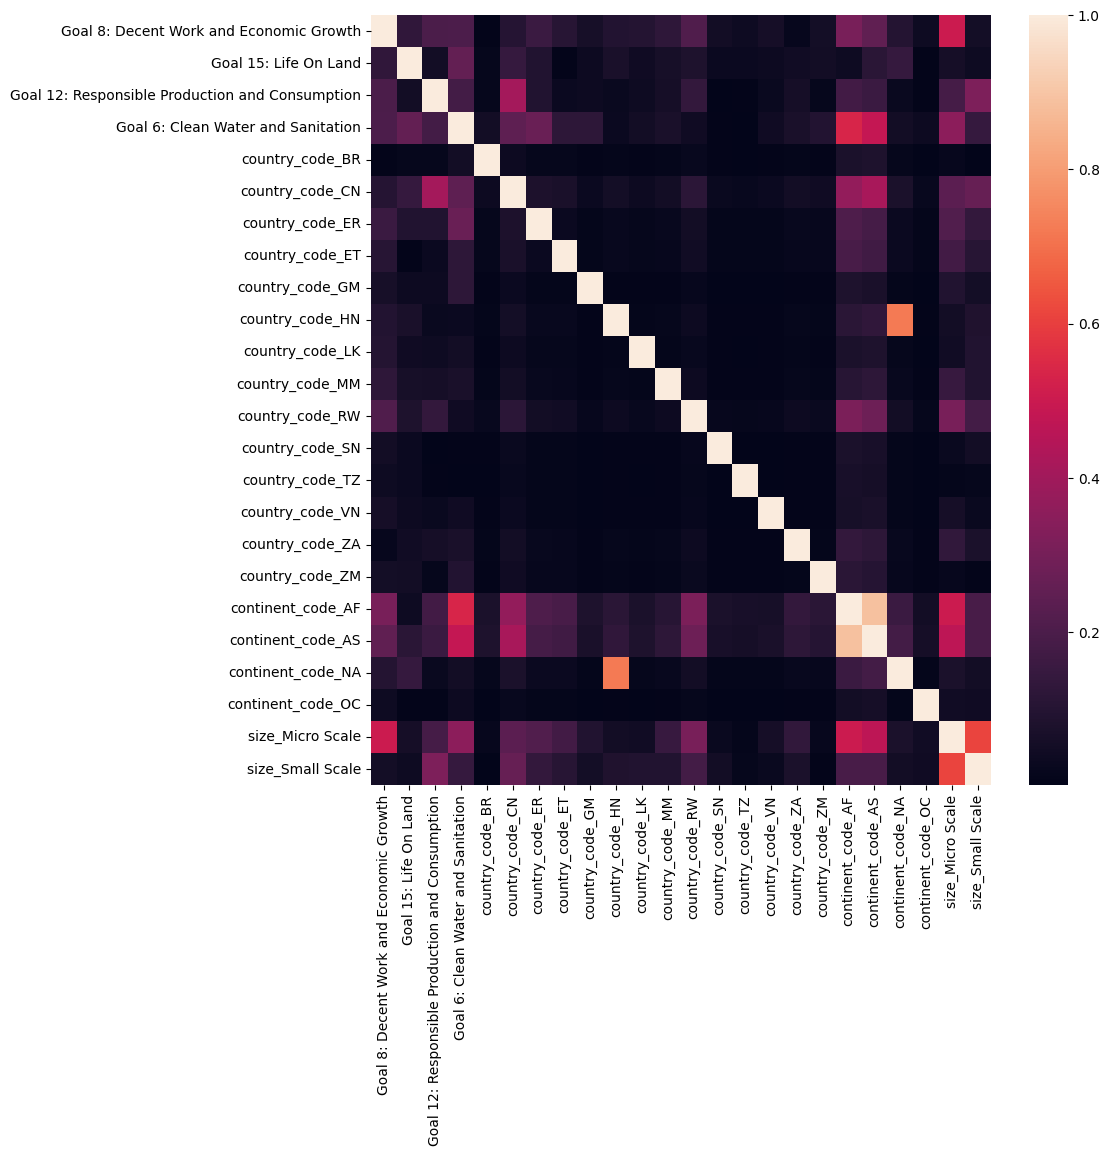

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_data.corr().abs())

In [ ]:
def abs_error(y,y_pred):
    return(np.mean(np.absolute(y-y_pred)))
abs_error_scorer=make_scorer(abs_error,greater_is_better=False)

In [ ]:
X=corr_data
y=data['VER_percentage_sold']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
ETR=ExtraTreesRegressor(10)
SV=SVR()
MLP=MLPRegressor(max_iter=500)
DT=DecisionTreeRegressor()
NN=KNeighborsRegressor()
ETRscores=cross_val_score(ETR,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
SVRscores=cross_val_score(SV,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
MLPscores=cross_val_score(MLP,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
DTscores=cross_val_score(DT,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)
NNscores=cross_val_score(NN,X_train,y_train,cv=5,scoring=abs_error_scorer,n_jobs=-1)

In [ ]:
def score_print(cv):
    print(np.absolute(cv.mean()),'+/-',cv.std())

In [ ]:
print('Extra Trees Regressor Score:')
score_print(ETRscores)
print('Support Vector Regressor Score:')
score_print(SVRscores)
print('Neural Network Score:')
score_print(MLPscores)
print('Decision Tree Regressor Score:')
score_print(DTscores)
print('Nearest Neighbour Regressor Score:')
score_print(NNscores)

Extra Trees Regressor Score:
0.26989952896841424 +/- 0.008077752622476344
Support Vector Regressor Score:
0.2619699508430861 +/- 0.011333558789285367
Neural Network Score:
0.2674861821641135 +/- 0.008345622491284115
Decision Tree Regressor Score:
0.26997784407321673 +/- 0.00808313636915064
Nearest Neighbour Regressor Score:
0.27396565854934163 +/- 0.009792695048086247


In [ ]:
SV.fit(X_train,y_train)
abs_error(y_test,SV.predict(X_test))

0.29700584962983995